
Processing Fret 1: ['11.csv', '12.csv']

Processing Fret 2: ['21.csv', '22.csv']

Processing Fret 3: ['31.csv', '32.csv']

Processing Fret 4: ['41.csv', '42.csv']

Processing Fret 5: ['51.csv', '52.csv']

Processing Fret 6: ['61.csv', '62.csv']

Processing Fret 7: ['71.csv', '72.csv']

Processing Fret 8: ['81.csv', '82.csv']

Processing Fret 9: ['91.csv', '92.csv']

Processing Fret 10: ['101.csv', '102.csv']


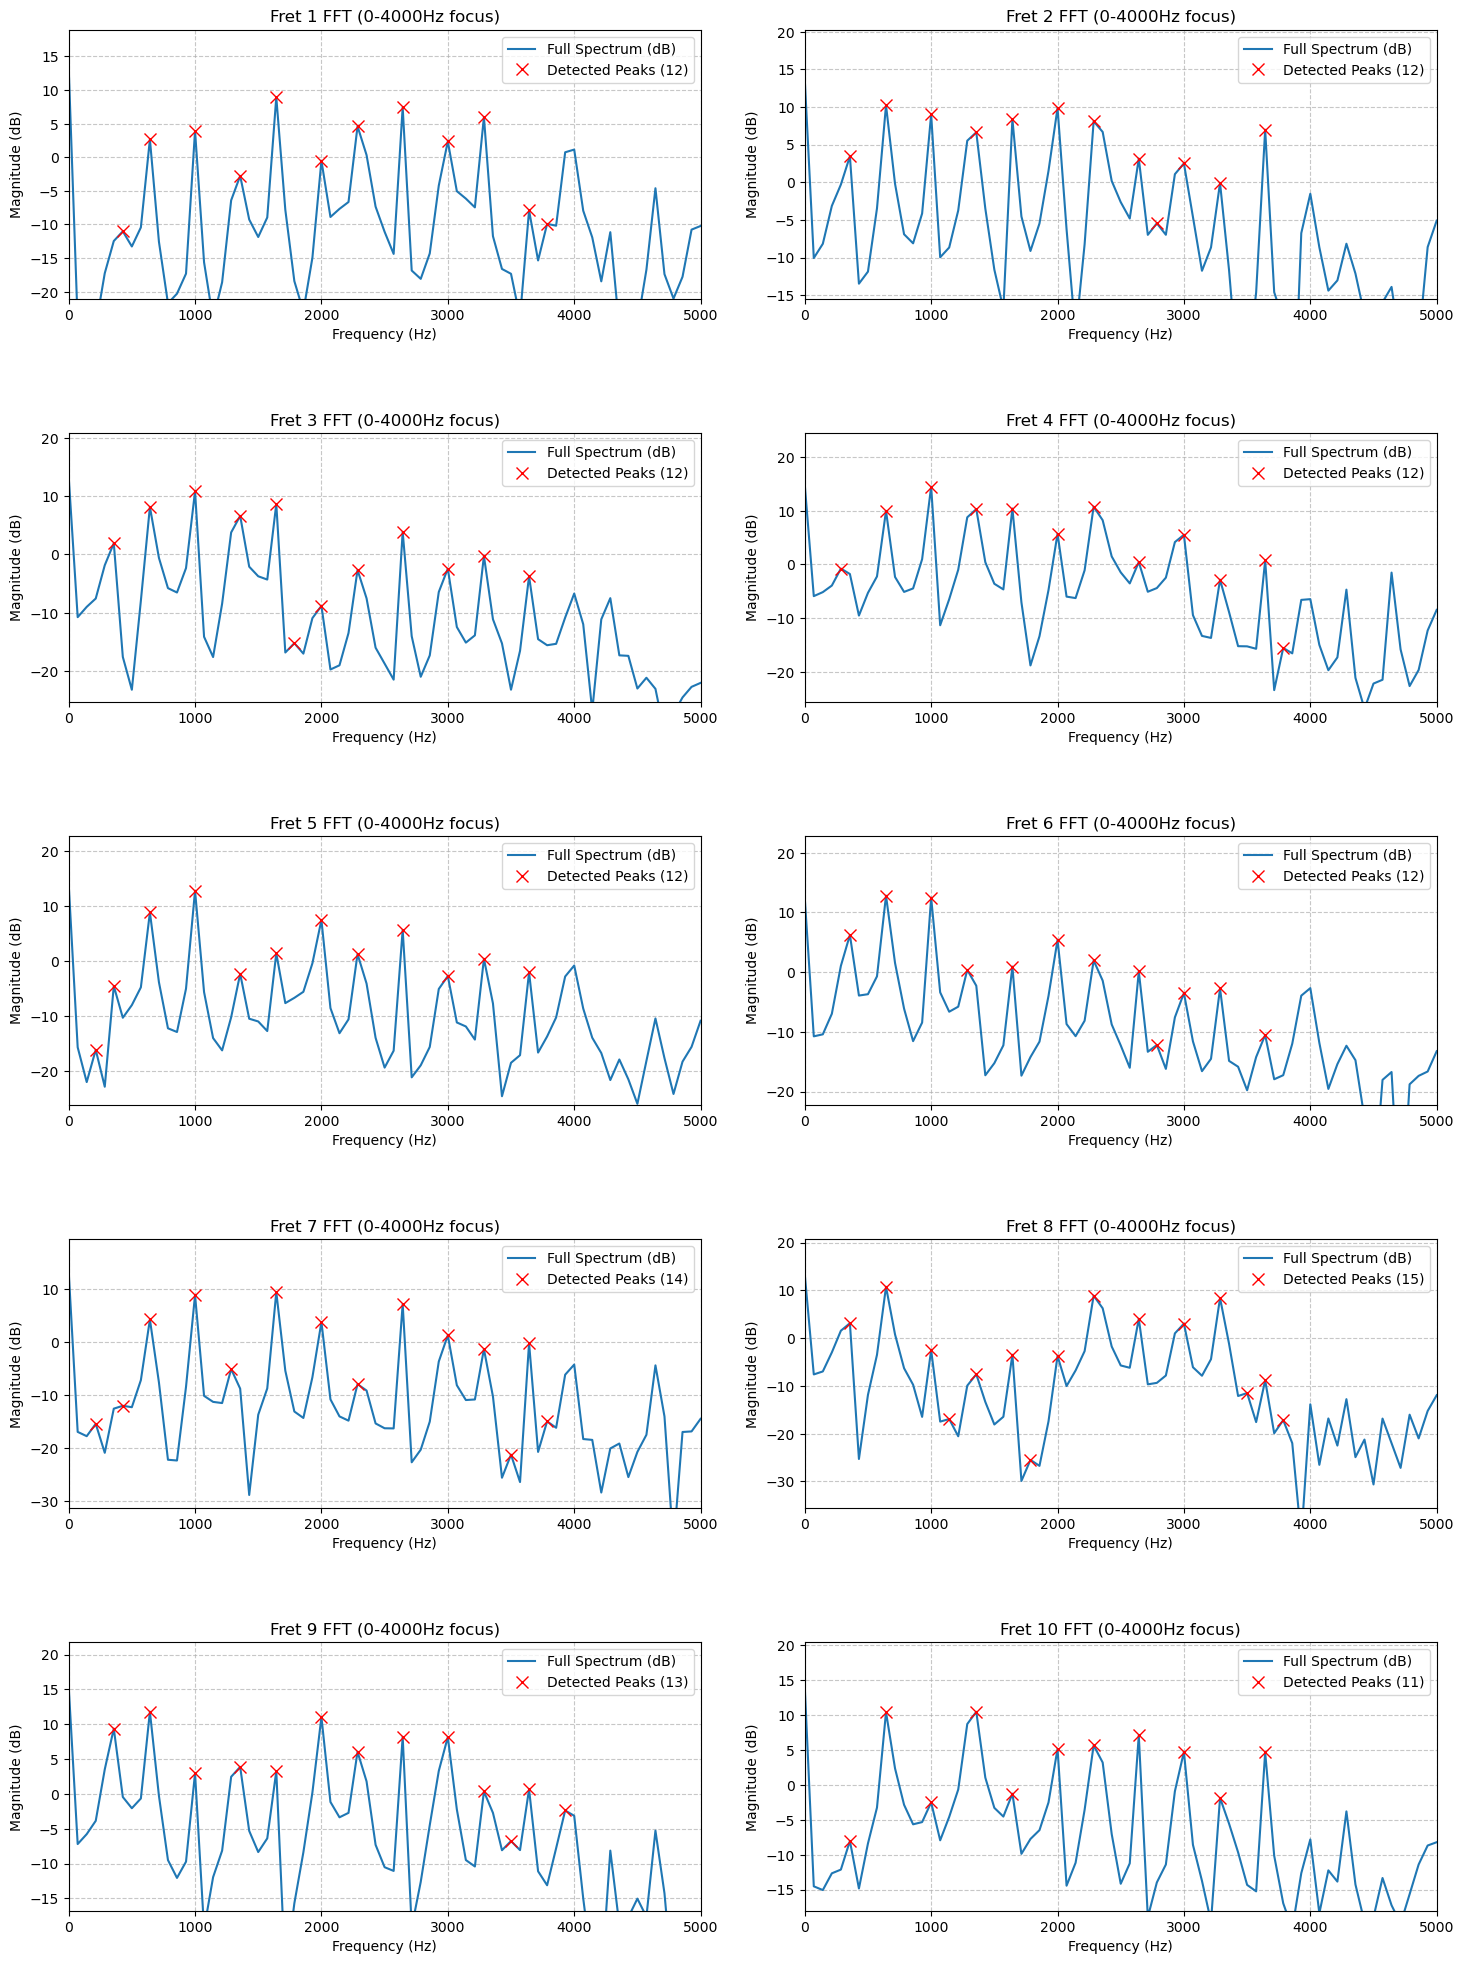


--- Detected Peaks (Refined) ---
Fret 1:
  Frequency: 428.57 Hz, Magnitude: -11.01 dB
  Frequency: 642.86 Hz, Magnitude: 2.66 dB
  Frequency: 1000.00 Hz, Magnitude: 3.92 dB
  Frequency: 1357.14 Hz, Magnitude: -2.78 dB
  Frequency: 1642.86 Hz, Magnitude: 8.92 dB
  Frequency: 2000.00 Hz, Magnitude: -0.52 dB
  Frequency: 2285.71 Hz, Magnitude: 4.60 dB
  Frequency: 2642.86 Hz, Magnitude: 7.41 dB
  Frequency: 3000.00 Hz, Magnitude: 2.35 dB
  Frequency: 3285.71 Hz, Magnitude: 5.97 dB
  Frequency: 3642.86 Hz, Magnitude: -7.91 dB
  Frequency: 3785.71 Hz, Magnitude: -9.91 dB
Fret 2:
  Frequency: 357.14 Hz, Magnitude: 3.44 dB
  Frequency: 642.86 Hz, Magnitude: 10.22 dB
  Frequency: 1000.00 Hz, Magnitude: 8.99 dB
  Frequency: 1357.14 Hz, Magnitude: 6.63 dB
  Frequency: 1642.86 Hz, Magnitude: 8.37 dB
  Frequency: 2000.00 Hz, Magnitude: 9.86 dB
  Frequency: 2285.71 Hz, Magnitude: 8.09 dB
  Frequency: 2642.86 Hz, Magnitude: 3.13 dB
  Frequency: 2785.71 Hz, Magnitude: -5.45 dB
  Frequency: 3000.00 H

In [22]:
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt # Uncomment if you want to use plotting

# --- Constants and Data Structures ---
data_by_fret = {
    1: ['11.csv', '12.csv'],
    2: ['21.csv', '22.csv'],
    3: ['31.csv', '32.csv'],
    4: ['41.csv', '42.csv'],
    5: ['51.csv', '52.csv'],
    6: ['61.csv', '62.csv'],
    7: ['71.csv', '72.csv'],
    8: ['81.csv', '82.csv'],
    9: ['91.csv', '92.csv'],
    10: ['101.csv', '102.csv']
}

# x_m = 0.615 # Unused in current script logic
# L = 0.653   # Unused in current script logic
dt = 10**-5  # Sampling time interval (seconds), confirmed from CSV header as a good approximation
# sampling_frequency = 1 / dt # Calculated but not directly used later, dt is used

peak_data = {} # To store peak (frequency, magnitude_dB) tuples for each fret

# --- Optional: Setup for plotting ---
fig, axs = plt.subplots(5, 2, figsize=(15, 20)) # nrows=5, ncols=2 for 10 frets
axs = axs.flatten() # Flatten to 1D array for easier indexing if using subplots

# --- Main Processing Loop ---
for fret_number, file_list in data_by_fret.items():
    print(f"\nProcessing Fret {fret_number}: {file_list}")
    signals = []

    # Read signals for the current fret
    for filename in file_list:
        try:
            # Read only the second column (voltage), skip the first two header lines
            data = np.loadtxt(filename, delimiter=',', skiprows=2, usecols=1)
            signals.append(data)
        except Exception as e:
            print(f"  Error reading {filename}: {e}")
            continue

    if not signals:
        print(f"  Warning: No valid signals loaded for Fret {fret_number}. Skipping.")
        peak_data[fret_number] = [] # Store empty list
        # if fret_number -1 < len(axs): # For plotting
        #     axs[fret_number-1].text(0.5, 0.5, 'No data', ha='center', va='center')
        #     axs[fret_number-1].set_title(f"Fret {fret_number} - No Data")
        continue

    # Convert list to array and average across trials
    signals_array = np.array(signals)
    avg_signal = np.mean(signals_array, axis=0)

    # --- Perform FFT ---
    N_fft = len(avg_signal)
    if N_fft == 0:
        print(f"  Warning: Averaged signal for Fret {fret_number} is empty. Skipping FFT.")
        peak_data[fret_number] = []
        # if fret_number -1 < len(axs): # For plotting
        #     axs[fret_number-1].text(0.5, 0.5, 'Empty signal', ha='center', va='center')
        #     axs[fret_number-1].set_title(f"Fret {fret_number} - Empty Signal")
        continue

    full_freq_axis = np.fft.rfftfreq(N_fft, dt)       # Full frequency axis
    full_fft_result = np.fft.rfft(avg_signal)
    full_magnitude_spectrum = np.abs(full_fft_result) # Full linear magnitude spectrum
    # full_magnitude_db = 20 * np.log10(full_magnitude_spectrum + 1e-12) # Full spectrum in dB for plotting

    # --- START: Refined Peak Finding in 0-4000 Hz Range ---
    min_freq_filter = 0
    max_freq_filter = 4000  # Hz

    # Find indices corresponding to the desired frequency range
    try:
        idx_filter_range = np.where((full_freq_axis >= min_freq_filter) & (full_freq_axis <= max_freq_filter))[0]

        if idx_filter_range.size == 0:
            # print(f"  Fret {fret_number}: No frequencies found in the range {min_freq_filter}-{max_freq_filter} Hz.")
            freq_slice_for_peaks = np.array([])
            magnitude_slice_for_peaks = np.array([])
            start_index_for_mapback = 0 # Won't be used if slice is empty
        else:
            freq_slice_for_peaks = full_freq_axis[idx_filter_range]
            magnitude_slice_for_peaks = full_magnitude_spectrum[idx_filter_range]
            start_index_for_mapback = idx_filter_range[0] # Index in full_freq_axis where the slice begins

    except Exception as e_slice:
        print(f"  Error selecting frequency range for Fret {fret_number}: {e_slice}. Defaulting to full spectrum for peak finding.")
        freq_slice_for_peaks = full_freq_axis # Fallback
        magnitude_slice_for_peaks = full_magnitude_spectrum # Fallback
        start_index_for_mapback = 0 # Fallback

    current_fret_peak_freqs = np.array([])
    current_fret_peak_mags_linear = np.array([])

    if magnitude_slice_for_peaks.size > 0:
        # --- Tune these parameters for find_peaks ---
        # Prominence is often key for detecting peaks relative to their local neighborhood
        # Adjust the factor (0.01 to 0.1 is a common range to start experimenting with)
        estimated_prominence = np.max(magnitude_slice_for_peaks) * 0.001 # Example: 2% of max in the slice
        # Height can also be used, e.g., only peaks above the median or a certain fraction of max
        # min_height_in_slice = np.median(magnitude_slice_for_peaks)
        # min_height_in_slice = np.max(magnitude_slice_for_peaks) * 0.01

        peaks_in_slice_indices, properties = find_peaks(
            magnitude_slice_for_peaks,
            prominence=estimated_prominence, # Tune this!
            # height=min_height_in_slice,   # Optionally add height constraint
            distance=2  # Minimum number of samples between peaks. Adjust based on FFT resolution.
                        # FFT resolution df = (1/dt) / N_fft.
                        # If df is e.g. 5 Hz, and harmonics are 300Hz apart, distance=5 might be too small
                        # if peaks are very broad. If peaks are sharp, 5-10 is often fine.
        )

        if peaks_in_slice_indices.size > 0:
            # Map indices from the slice back to the original full spectrum
            actual_peak_indices_in_full = start_index_for_mapback + peaks_in_slice_indices
            current_fret_peak_freqs = full_freq_axis[actual_peak_indices_in_full]
            current_fret_peak_mags_linear = full_magnitude_spectrum[actual_peak_indices_in_full]
        # else:
            # print(f"  Fret {fret_number}: No peaks found in slice with current find_peaks settings.")
    # else:
        # print(f"  Fret {fret_number}: Magnitude slice for peak finding is empty.")
    # --- END: Refined Peak Finding ---

    # Store refined peak data (frequencies and magnitudes in dB)
    if current_fret_peak_freqs.size > 0:
        # Sort peaks by frequency before storing (find_peaks usually does, but good practice)
        sort_order = np.argsort(current_fret_peak_freqs)
        current_fret_peak_freqs = current_fret_peak_freqs[sort_order]
        current_fret_peak_mags_linear = current_fret_peak_mags_linear[sort_order]

        # Convert linear magnitudes to dB for storage
        peak_data[fret_number] = list(zip(current_fret_peak_freqs, 20 * np.log10(current_fret_peak_mags_linear + 1e-12)))
        # print(f"  Fret {fret_number}: Found {len(peak_data[fret_number])} peaks in {min_freq_filter}-{max_freq_filter} Hz range.")
    else:
        # print(f"  Fret {fret_number}: No peaks detected in the specified range or with current settings.")
        peak_data[fret_number] = []

    # --- Optional: Plotting for the current fret ---
    if fret_number-1 < len(axs):
        ax_current = axs[fret_number-1]
         # Plot full spectrum in dB within a reasonable range (e.g., up to 5000 Hz for visualization)
        plot_freq_limit_idx = np.where(full_freq_axis <= max_freq_filter + 1000)[0] # Show a bit beyond 4kHz
        if plot_freq_limit_idx.size > 0:
            ax_current.plot(full_freq_axis[plot_freq_limit_idx], 20 * np.log10(full_magnitude_spectrum[plot_freq_limit_idx] + 1e-12), label='Full Spectrum (dB)')
        else: # Fallback if even 5kHz is out of range
            ax_current.plot(full_freq_axis, 20 * np.log10(full_magnitude_spectrum + 1e-12), label='Full Spectrum (dB)')


         # Mark the detected peaks (from the refined search)
        if current_fret_peak_freqs.size > 0:
             # Magnitudes are already converted to dB in peak_data
            stored_peak_mags_db = [item[1] for item in peak_data[fret_number]]
            ax_current.plot(current_fret_peak_freqs, stored_peak_mags_db, "x", color='red', markersize=8, label=f'Detected Peaks ({len(current_fret_peak_freqs)})')
        
        ax_current.set_title(f"Fret {fret_number} FFT (0-{max_freq_filter}Hz focus)")
        ax_current.set_xlabel("Frequency (Hz)")
        ax_current.set_ylabel("Magnitude (dB)")
        ax_current.set_xlim([0, max_freq_filter + 1000]) # Zoom in on the relevant area for plotting
         # Determine dynamic Y-axis limits for better visualization
        if current_fret_peak_freqs.size > 0:
            min_mag_plot = min(stored_peak_mags_db) - 10
            max_mag_plot = max(stored_peak_mags_db) + 10
            ax_current.set_ylim([max(min_mag_plot, -80), max_mag_plot]) # Avoid extremely low dB values
        elif magnitude_slice_for_peaks.size > 0:
            min_mag_plot = np.min(20 * np.log10(magnitude_slice_for_peaks + 1e-12)) -10
            max_mag_plot = np.max(20 * np.log10(magnitude_slice_for_peaks + 1e-12)) +10
            ax_current.set_ylim([max(min_mag_plot, -80), max_mag_plot])


        ax_current.grid(True, which='both', linestyle='--', alpha=0.7)
        ax_current.legend()

# --- Optional: Finalize and show plot ---
plt.tight_layout(pad=2.0)
plt.subplots_adjust(hspace=0.5) # Add more vertical space between subplots
plt.show()


# --- Print raw peak data (as before, now using refined peaks) ---
print("\n--- Detected Peaks (Refined) ---")
for fret, peaks_list in peak_data.items():
    print(f"Fret {fret}:")
    if peaks_list:
        for freq_val, mag_val in peaks_list:
            print(f"  Frequency: {freq_val:.2f} Hz, Magnitude: {mag_val:.2f} dB")
    else:
        print("  No peaks found in the specified range or with current settings.")


# --- Harmonic Cleaning (using the refined peak_data) ---
# This part of your code should now work with the more accurately detected peaks

# Define fundamental_freqs dictionary.
# If you want fret-dependent f0s, populate this dictionary:
# Example: fundamental_freqs = {1: 82.41, 2: 87.31, ..., 10: 123.47} # E2, F2, ..., B2
fundamental_freqs = {} # DEFAULT: Empty if using a single f0 for all frets.

# For a single expected f0 across all frets (if fundamental_freqs is empty or key not found):
single_expected_f0 = 330 # Hz (e.g., E4 note - adjust if your target is different)
tolerance = 50  # Hz tolerance for matching harmonics - you might make this tighter now
                # e.g. tolerance = current_expected_f0 * 0.05 (5% of the current f0)

cleaned_peak_data = {}
print("\n--- Cleaned Harmonic Data ---")

for fret_number, peaks_list_for_fret in peak_data.items():
    # Determine expected_f0 for the current fret
    current_expected_f0 = fundamental_freqs.get(fret_number, single_expected_f0)

    harmonics_for_fret = []
    if not peaks_list_for_fret: # If no peaks were found for this fret earlier
        # print(f"Fret {fret_number}: No raw peaks to clean. Storing placeholders for harmonics based on f0={current_expected_f0:.2f} Hz.")
        for n_harmonic in range(1, 11): # First 10 harmonics
            target_h_freq = current_expected_f0 * n_harmonic
            harmonics_for_fret.append((target_h_freq, 0.0)) # Placeholder
        cleaned_peak_data[fret_number] = harmonics_for_fret
        continue

    # Unzip the (freq, mag_dB) tuples from peak_data for the current fret
    detected_freqs_for_fret, detected_mags_db_for_fret = zip(*peaks_list_for_fret)
    detected_freqs_for_fret_np = np.array(detected_freqs_for_fret) # Convert to numpy array for efficiency

    current_tolerance = current_expected_f0 * 0.1 # Example: tolerance as 10% of current_expected_f0

    for n_harmonic in range(1, 11):  # Looking for the first 10 harmonics
        target_harmonic_freq = current_expected_f0 * n_harmonic

        # Calculate absolute differences
        diffs_to_target = np.abs(detected_freqs_for_fret_np - target_harmonic_freq)

        if diffs_to_target.size > 0 and np.min(diffs_to_target) < current_tolerance: # Use current_tolerance
            closest_peak_idx = np.argmin(diffs_to_target)
            # Append the actual detected frequency and its magnitude (already in dB)
            harmonics_for_fret.append((detected_freqs_for_fret_np[closest_peak_idx], detected_mags_db_for_fret[closest_peak_idx]))
        else:
            # If no detected peak is within tolerance, append a placeholder
            harmonics_for_fret.append((target_harmonic_freq, 0.0)) # Magnitude 0.0 dB

    cleaned_peak_data[fret_number] = harmonics_for_fret

# --- Storing Magnitudes in Ratios Array and Printing Cleaned Data ---
# Initialize ratios array (assuming frets 1-10, and 10 harmonics)
# Shape: (max_fret_number + 1, num_harmonics) to use fret_number directly as index
max_fret = max(data_by_fret.keys()) if data_by_fret else 0
num_harmonics_to_store = 10
ratios_db = np.full((max_fret + 1, num_harmonics_to_store), np.nan) # Use NaN for missing data

for fret_number, harmonic_data_list in cleaned_peak_data.items():
    f0_for_display = fundamental_freqs.get(fret_number, single_expected_f0) # Get f0 used for this fret
    print(f"Cleaned Fret {fret_number} (Target f0: {f0_for_display:.2f} Hz):")
    for i_harmonic, (freq_val, mag_val) in enumerate(harmonic_data_list):
        if i_harmonic < num_harmonics_to_store: # Ensure we don't go out of bounds for ratios_db
            print(f"  H{i_harmonic+1}: Freq: {freq_val:.2f} Hz, Mag: {mag_val:.2f} dB")
            if 0 < fret_number < ratios_db.shape[0]: # Check fret_number bounds
                 ratios_db[fret_number, i_harmonic] = mag_val
        else:
            print(f"  (Extra harmonic data for Fret {fret_number} beyond {num_harmonics_to_store} not stored in ratios_db)")

# print("\n--- Ratios (Magnitudes in dB) ---")
# print("Rows: Fret Number, Columns: Harmonic Number (H1 to H10)")
# print(ratios_db[1:]) # Print from Fret 1 onwards, assuming Fret 0 is not used or is NaN
